In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.model_selection import  GridSearchCV
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.font_manager as fm
from sklearn.decomposition import PCA
import collections
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,Flatten,Dropout,SimpleRNN,LSTM, MaxPooling1D,AveragePooling1D,GlobalAvgPool1D
from tensorflow.keras.callbacks import EarlyStopping
import math

In [9]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto' )

In [10]:

font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_path = r'C:/Windows/Fonts/H2GTRM.TTF' # HY견명조 폰트 경로

# 2. FontProperties 객체 생성
font_prop = fm.FontProperties(fname=font_path).get_name()

# 3. 마이너스 부호 설정 (필요한 경우)
plt.rc('font', family=font_prop)

plt.rc('axes', unicode_minus=False)

In [11]:
def create_sequence(data, window_size,target_name):
    y_data= data[target_name].values
    data = data.values
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(y_data[i + window_size])
    X, y = np.array(X), np.array(y)
    return X,y

In [12]:
def stepwise_selection(X, y,
					   initial_list=[],
					   threshold_in=0.05,
					   threshold_out=0.10,
					   verbose=True):
	"""
	Perform a stepwise feature selection based on p-values from statsmodels OLS.

	Parameters:
	- X : pd.DataFrame
		Candidate feature set (independent variables).
	- y : pd.Series or np.array
		Target variable (dependent variable).
	- initial_list : list
		Initial list of features to start the selection process.
	- threshold_in : float
		p-value threshold for adding a feature (smaller = more strict).
	- threshold_out : float
		p-value threshold for removing a feature (larger = more lenient).
	- verbose : bool
		Whether to print progress during feature selection.

	Returns:
	- included : list
		The final list of selected features.
	"""

	included = list(initial_list)  # Start with an initial list (could be empty)

	while True:
		changed = False  # Flag to track whether any feature was added or removed in the current iteration; If not, the loop will break

		# --- Forward Step ---
		# Try adding each feature not yet included and check p-values
		excluded = list(set(X.columns) - set(included))  # Compute the list of features not yet included in the model; These are the candidates for addition
		new_pval = pd.Series(index=excluded, dtype=float)  # Initialise a Series to store the p-values of each excluded feature if it were to be added to the model
		for new_column in excluded: # Iterate over all excluded features to assess their contribution
			# Fit OLS model with the current included features + this new one
			X_with_const = sm.add_constant(X[included + [new_column]]) # Prepare the design matrix with a constant term (intercept) and the current included features plus the candidate new feature
			model = sm.OLS(y, X_with_const).fit() # Fits an Ordinary Least Squares (OLS) linear regression model to the current design matrix
			new_pval[new_column] = model.pvalues[new_column]  # Extract the p-value of the newly added feature and stores it

		# Add the feature with the lowest p-value if it's below threshold_in
		if not new_pval.empty and new_pval.min() < threshold_in: # Check whether the smallest p-value among the excluded features is statistically significant, i.e., below the inclusion threshold
			best_pval = new_pval.idxmin()  # Feature with the smallest p-value
			included.append(best_pval)
			changed = True
			if verbose:
				print(f'Add {best_pval} with p-value {new_pval.min():.6f}')

		# --- Backward Step ---
		# Now check if any included feature should be removed
		X_with_const = sm.add_constant(X[included])
		model = sm.OLS(y, X_with_const).fit() # Re-fit the model using the current set of included features to re-calculate all p-values
		pvalues = model.pvalues.iloc[1:]  # Get p-values for all features excluding the intercept (which is the first value); These are the features being evaluated for possible removal

		# If any included feature has a p-value above threshold_out, remove the worst one
		if not pvalues.empty and pvalues.max() > threshold_out: # If the worst (largest) p-value among included features exceeds the exclusion threshold, it’s a candidate for removal
			worst_pval = pvalues.idxmax() # Find the feature with the worst (largest) p-value
			included.remove(worst_pval) # Remove this feature from the model
			changed = True
			if verbose:
				print(f'Drop {worst_pval} with p-value {pvalues.max():.6f}')

		# If no feature was added or removed, the process is done
		if not changed:
			break

	# Print final selected features and summary
	if verbose:
		print("\nFinal Selected Variables:")
		print(included)
		final_X_with_const = sm.add_constant(X[included])
		final_model = sm.OLS(y, final_X_with_const).fit()
		print("\nFinal Model Summary:")
		print(final_model.summary())

	return included

In [13]:
def get_saturday(date):
    days_to_saturday = (5 - date.weekday()) % 7
    return date + pd.Timedelta(days=days_to_saturday)

# 데이터 셋 

1. 수온 + 기상 
2. 수온 + 기상 + CNN 특징
3. 수온 + 기상 + CNN + Target
4. 바다환경 
5. 바다환경 + 해상부이
6. 바다환경+ 해상부이+Target

타겟: 어종별 어획률/어획량

In [83]:
# 어획률 데이터
rate = pd.read_excel('data/어류어획률+어획량.xlsx',sheet_name='어획률')[1:]
rate.fillna(0,inplace=True)
num = pd.read_excel('data/어류어획률+어획량.xlsx',sheet_name='어획량')[1:]
num.fillna(0,inplace=True)

target = rate.columns[1:].to_list()

# 데이터 불러오기

In [84]:
# 바다온도 + 기상
ocean_data_1 = pd.read_csv('data/surface_Tm+Weather.csv')
ocean_data_1.drop(columns=['관측소'],inplace=True)
ocean_data_1['date'] = pd.to_datetime(ocean_data_1['date'])
ocean_data_1['Week']=ocean_data_1['date'].apply(get_saturday)
ocean_data_1=ocean_data_1.groupby('Week').mean().reset_index().drop(columns='date')
ocean_data_1_rate = rate.merge(ocean_data_1,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_1_rate.set_index('Date',inplace=True)
ocean_data_1_num = num.merge(ocean_data_1,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_1_num.set_index('Date',inplace=True)



# 바다온도 + 기상 + CNN
ocean_data_2 = pd.read_csv('data/surface_Tm+weather+cnn.csv')
ocean_data_2.drop(columns=['관측소'],inplace=True)
ocean_data_2['Date'] = pd.to_datetime(ocean_data_2['Date'])
ocean_data_2['Week']=ocean_data_2['Date'].apply(get_saturday)
ocean_data_2=ocean_data_2.groupby('Week').mean().reset_index().drop(columns='Date')
ocean_data_2_rate = rate.merge(ocean_data_2,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_2_rate.set_index('Date',inplace=True)
ocean_data_2_num = num.merge(ocean_data_2,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_2_num.set_index('Date',inplace=True)

# 바다온도 + 기상 + CNN + 타겟
ocean_data_3 = pd.read_csv('data/surface_Tm+weather+cnn+target.csv')
ocean_data_3['Date'] = pd.to_datetime(ocean_data_3['Date'])
ocean_data_3['Week']=ocean_data_3['Date'].apply(get_saturday)
ocean_data_3=ocean_data_3.groupby('Week').mean().reset_index().drop(columns='Date')
ocean_data_3_rate = rate.merge(ocean_data_3,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_3_rate.set_index('Date',inplace=True)
ocean_data_3_num = num.merge(ocean_data_3,left_on='Date',right_on='Week',how='right').drop(columns=['Week'])
ocean_data_3_num.set_index('Date',inplace=True)

# 바다성분 
ocean_data_4 = pd.read_csv('data/ocean_env.csv')
ocean_data_4['time'] = pd.to_datetime(ocean_data_4['time'])
ocean_data_4['Week']=ocean_data_4['time'].apply(get_saturday)
ocean_data_4=ocean_data_4.groupby('Week').mean().reset_index().drop(columns='time')
ocean_data_4_rate = rate.merge(ocean_data_4,left_on='Date',right_on='Week',how='left').drop(columns=['Week'])
ocean_data_4_rate.set_index('Date',inplace=True)
ocean_data_4_num = num.merge(ocean_data_4,left_on='Date',right_on='Week',how='left').drop(columns=['Week'])
ocean_data_4_num.set_index('Date',inplace=True)

# 바다성분 + 기상
ocean_data_5 = pd.read_csv('data/Ocean_env+Ocean_weather.csv')
ocean_data_5['time'] = pd.to_datetime(ocean_data_5['time'])
ocean_data_5['Week']=ocean_data_5['time'].apply(get_saturday)
ocean_data_5=ocean_data_5.groupby('Week').mean().reset_index().drop(columns='time')
ocean_data_5_rate = rate.merge(ocean_data_5,left_on='Date',right_on='Week',how='left').drop(columns=['Week'])
ocean_data_5_rate.set_index('Date',inplace=True)
ocean_data_5_num = num.merge(ocean_data_5,left_on='Date',right_on='Week',how='left').drop(columns=['Week'])
ocean_data_5_num.set_index('Date',inplace=True)
# 다 파이널
ocean_data_6 = pd.read_csv('data/rate_ocean_final.csv')

# 특성 추출  CNN

In [58]:
#CNN으로 특징 추출 
def CNN_feature(data):
    X = data.drop(columns=target)
    y= data[target]
    y.reset_index(drop=True,inplace=True)
    
    data = np.expand_dims(X,axis=0)
    
    CNN_feature = Sequential()
    CNN_feature.add(Conv1D(filters=64, kernel_size=4,activation='relu',input_shape=(data.shape[1],data.shape[2]),padding='same'))
    CNN_feature.add(Conv1D(filters=32, kernel_size=4,activation='relu',padding='same'))
    CNN_feature.add(Conv1D(filters=16, kernel_size=4,activation='relu',padding='same'))
    CNN_feature.add(Conv1D(filters=8, kernel_size=4,activation='relu',padding='same'))

    CNN_feature.summary()

    CNN_features = CNN_feature.predict(data)

    feature_vector = CNN_features[0]
    print(feature_vector)
    feature_columns = [f'cnn_feat_{i}' for i in range(feature_vector.shape[1])]
    df_CNN_features = pd.DataFrame(data=feature_vector,columns=feature_columns)
    df_CNN_features = pd.concat([df_CNN_features,y],axis=1)
    return df_CNN_features

In [86]:
cnn_df = CNN_feature(ocean_data_5_rate)


c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_50 (Conv1D)              │ (None, 727, 64)        │        16,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_51 (Conv1D)              │ (None, 727, 32)        │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_52 (Conv1D)              │ (None, 727, 16)        │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_53 (Conv1D)              │ (None, 727, 8)         │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,512 (107.47 KB)

 Trainable params: 27,512 (107.47 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
[[136.48642     0.         20.465557  ...  10.005592  215.15756
   82.56757  ]
 [105.59979     0.        133.21942   ...  46.326233  229.69437
  192.16626  ]
 [115.557556    0.        135.78355   ... 106.58305   227.76175
  125.62288  ]
 ...
 [  1.6482773   0.         91.64873   ... 107.118546   93.62049
  113.7019   ]
 [  0.          0.        107.978096  ... 103.19038    31.086857
   75.63253  ]
 [  0.         10.952971   39.97724   ...  72.40422     0.
    0.       ]]


In [344]:
target

In [28]:
#단계법을 통한 특성 추출
def step_select_feature(data,in_n,in_out):
    X = data.drop(target,axis=1)
    y = data[target]

    col=[]
    for i in target:
        select_col = stepwise_selection(X, y[i],threshold_in=in_n,threshold_out=in_out ,verbose=False)
        col.append(select_col)
    cb_item=[]
    for current_list in col:
        cb_item.extend(current_list)

    global_counts = collections.Counter(cb_item)
    sorted_counts = sorted(global_counts.items(), key=lambda item: item[1], reverse=True)
    for item, count in sorted_counts: # 정렬 없이 출력
        print(f"  '{str(item)}': {count}번")
    select_col = []
    for item,count in sorted_counts:
        if count>=2:
            select_col.append(item)
    select_col = select_col + target
    step_select_df = data[select_col]
    return step_select_df

In [27]:
step_df = step_select_feature(ocean_data_2_rate,0.01,0.01)
step_df

NameError: name 'step_select_feature' is not defined

# PCA

In [ ]:
def pca_feature(x, components,y=None) :
    pca =PCA(n_components=components)
    x_pca=pca.fit_transform(x)
    return x_pca,pca
 

# 슬라이딩윈도우 

In [31]:
def slide_scaler(data, window_size,target_name):
    
    X,y = create_sequence(data, window_size,target_name)
    split_index = int(len(X) * 0.8)
    X_train_raw, y_train_raw = X[:split_index], y[:split_index]
    X_test_raw, y_test_raw = X[split_index:], y[split_index:]
    feauture_num = X_train_raw.shape[2]
    
    scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    X_train_scaled = scaler.fit_transform(X_train_raw.reshape(-1, feauture_num)).reshape(X_train_raw.shape)
    X_test_scaled = scaler.transform(X_test_raw.reshape(-1, feauture_num)).reshape(X_test_raw.shape)
    y_train = y_scaler.fit_transform(y_train_raw.reshape(-1,y_train_raw.shape[1]))
    y_test = y_scaler.transform(y_test_raw.reshape(-1, y_test_raw.shape[1]))
    
    return X_train_scaled, y_train, X_test_scaled, y_test,y_test_raw,y_scaler
    

In [87]:
X_train,y_train,X_test,y_test,y_test_raw,y_scaler= slide_scaler(cnn_df,4,target)

In [55]:
X_train

array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,    

#'국호님 금주기원 기도 1일차'  
'아무 생각이 없ㄷ사 왜냐하면 아무생각이 없기 때문이다'  
'공감하는 바입니다'  
'기본 문법만 아는 사람은 어떻게 특징추출했는지 감도 안잡혀요 '  
'우건님 밤새도록 하시죠'  
'1년반 뒤면 29살 반'  
'우건님 ADsP 합격기원 기도 1일차'  
'전부 빅분기 합격기원 기도 1일차'  
'은서님 빠른 독립기원 기도 1일차'  
'기태님 회사 상장기원 기도 1일차'  


In [88]:
Cnn = Sequential()
Cnn.add(Conv1D(64,2, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
Cnn.add(MaxPooling1D(2))
Cnn.add(Flatten())
Cnn.add(Dense(32,activation = 'relu'))
Cnn.add(Dense(16,activation = 'relu'))
Cnn.add(Dense(y_train.shape[1]))
Cnn.compile(optimizer='adam', loss='mse')
Cnn.summary()

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_54 (Conv1D)              │ (None, 3, 64)          │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,711 (18.40 KB)

 Trainable params: 4,711 (18.40 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
Cnn_history = Cnn.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),callbacks=[early_stopping])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0687 - val_loss: 0.0507
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0350 - val_loss: 0.0472
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0285 - val_loss: 0.0436
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0265 - val_loss: 0.0427
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0274 - val_loss: 0.0401
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0286 - val_loss: 0.0390
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0265 - val_loss: 0.0395
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0276 - val_loss: 0.0375
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0257 - val_loss: 0.0375
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0261 - val_loss: 0.0376
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0241 - val_loss: 0.0387
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [ ]:
def percent(data,target_range,except_feature):
    y_pred = np.maximum(0,data)
    if except_feature is not None:
        total_y_pred = np.sum(y_pred,axis=1,keepdims=True)-np.sum(y_pred[:,except_feature],axis=1,keepdims=True)
    else:
        total_y_pred = np.sum(y_pred,axis=1,keepdims=True)
    zero = (total_y_pred==0).flatten()
    if np.any(zero):
        final_pred = 0
    elif except_feature is not None:
        final_pred = 
    else:
        normal_pred = y_pred/total_y_pred
        final_pred = normal_pred*target_range

    return final_pred

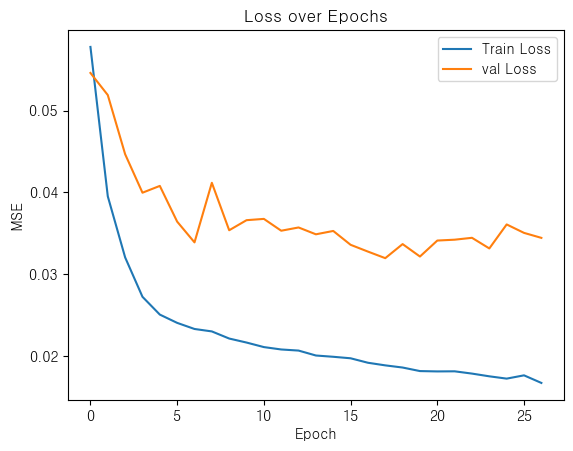

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MSE: 200.45819825848744
MAE: 10.664130408276089


In [81]:
plt.plot(Cnn_history.history['loss'], label='Train Loss')
plt.plot(Cnn_history.history['val_loss'], label='val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()
# y_pred= Cnn.predict(X_test)*100
y_pred_scaled = Cnn.predict(X_test)
y_pred= y_scaler.inverse_transform(y_pred_scaled)
y_pred =percent(y_pred,100)
mse= mean_squared_error(y_test_raw, y_pred)
mae= mean_absolute_error(y_test_raw, y_pred)
print('MSE:', mse)
print('MAE:', mae)

array([[54.668324  ,  7.255867  ,  8.245724  ,  6.5525913 , 16.051044  ,
         7.226451  ],
       [55.331654  ,  3.7050657 ,  8.190344  ,  9.367308  , 15.999873  ,
         7.405754  ],
       [51.748043  ,  2.7168546 , 12.280215  , 13.109835  , 11.337209  ,
         8.807851  ],
       [42.60216   ,  0.        , 15.233396  , 13.171676  , 22.840694  ,
         6.1520743 ],
       [35.011925  ,  0.        ,  0.        ,  8.8767    , 39.047718  ,
        17.063656  ],
       [55.54734   ,  7.551819  ,  2.4527814 ,  2.466117  , 26.324726  ,
         5.6572213 ],
       [48.575592  ,  9.531999  ,  1.3260553 ,  1.3130035 , 36.762333  ,
         2.4910169 ],
       [49.9288    ,  4.2202897 ,  6.4375257 ,  5.290262  , 26.284323  ,
         7.838805  ],
       [51.180794  ,  9.377886  ,  7.799811  ,  6.761349  , 16.843582  ,
         8.036578  ],
       [54.635746  ,  6.8181486 ,  9.124137  ,  8.797557  , 11.4859295 ,
         9.138477  ],
       [54.079525  ,  6.5777383 ,  8.040243  ,  5.

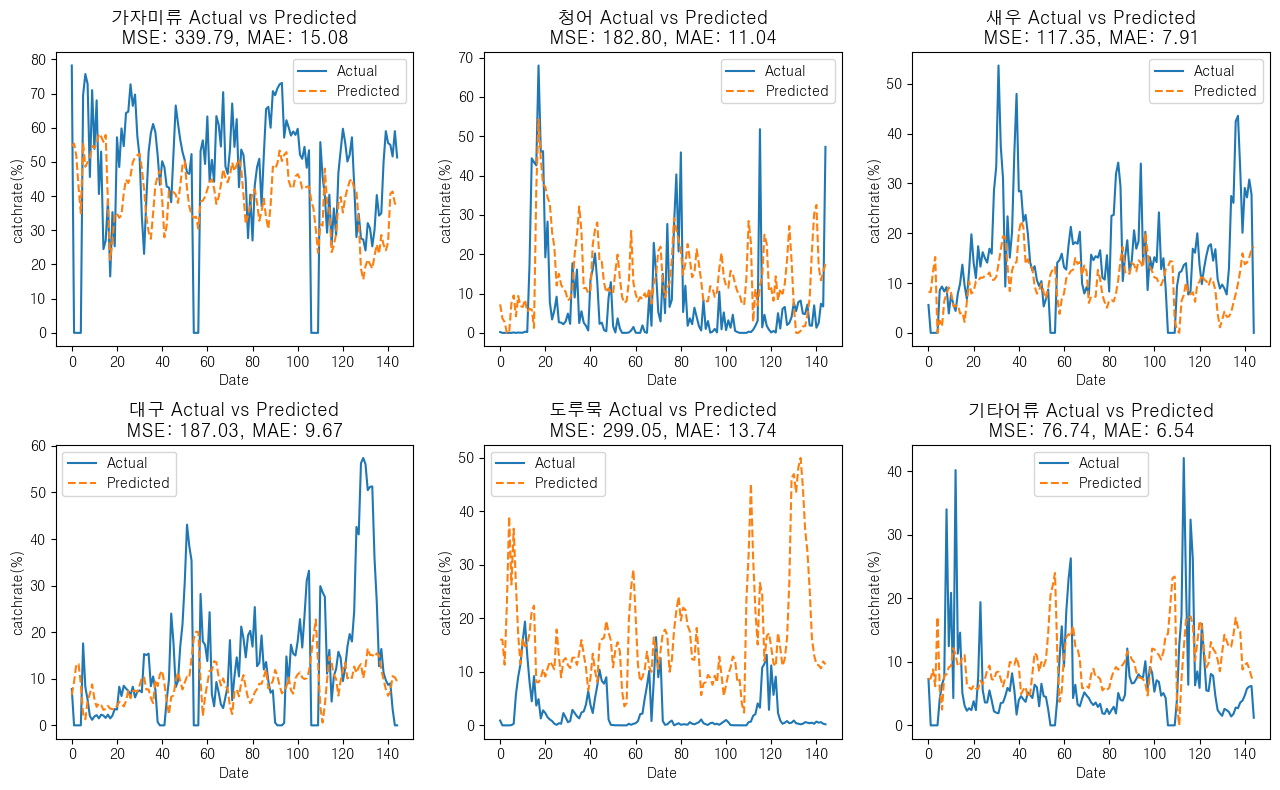

In [82]:
num_target = y_test_raw.shape[1]
target_name=['가자미류','청어','새우','대구','도루묵','기타어류']
n_cols = 3
n_rows = math.ceil(num_target / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, 8), squeeze=False)
axes_flat = axes.flatten()
last_plotted_idx = -1


for i, targets in enumerate(target_name):
    # 현재 모델이름에 위치하는 ax축 선택
    ax = axes_flat[i]
    mse_target = mean_squared_error(y_test_raw[:,i], y_pred[:,i])
    mae_target = mean_absolute_error(y_test_raw[:,i], y_pred[:,i])
    r2 = r2_score(y_test_raw[:,i], y_pred[:,i])
    # print(f'{targets} Mse: {mse_target:.4f}, Mae: {mae_target:.4f}')
    ax.plot(y_test_raw[:, i], label='Actual')
    ax.plot(y_pred[:, i], label='Predicted', linestyle='--')

    # 각 서브플롯 꾸미기
    ax.set_title(f'{targets} Actual vs Predicted\nMSE: {mse_target:.2f}, MAE: {mae_target:.2f}',fontsize=13,fontweight='bold')      # 플롯 제목 설정
    ax.set_xlabel('Date')                    # x축 레이블
    ax.set_ylabel('catchrate(%)')    # y축 레이블 (단위 확인 필요)                         # 그리드 표시
    ax.legend()                               # 범례 표시 확실히 하기
    last_plotted_idx = i
for j in range(last_plotted_idx+1, len(axes_flat)):
    axes_flat[j].set_visible(False)

# 전체 레이아웃 조정 및 플롯 보여주기
plt.tight_layout()
# tight_layout() 호출 후 suptitle 공간 확보

plt.show()

In [ ]:
def build_plot()

# ML(let's go)

In [358]:
xgb = XGBClassifier(random_state=42,)
xgb.fit(X_train_reshape,y_train)
y_pred = xgb.predict(X_test_reshape)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

In [438]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_reshape,y_train)
y_pred = dt.predict(X_test_reshape)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

In [434]:
# RF
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train,y_train)
y_pred=RF.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

In [ ]:
model_xgb = XGBClassifier(random_state=42)
hyperparams_xgb = {'n_estimators': [100, 200, 300],
				 'learning_rate': [0.01, 0.05, 0.1],
				 'max_depth': [3, 5, 7]}    
model_rf = RandomForestClassifier(random_state=42)
hyperparams_rf = {'n_estimators': [10, 50, 100],
				'max_depth': [None, 10, 20],
				'min_samples_split': [2, 5, 10],
				'min_samples_leaf': [1, 2, 4],
				'bootstrap': [True, False],}

In [ ]:
model_info = GridSearchCV(estimator=model_xgb,
                    param_grid = hyperparams_xgb,
                    cv=5)
model_info.fit(X_train,y_train)
model_n = model_info.best_estimator_
y_pred = model_n.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

In [ ]:
y_test_raw = y_test_raw.reshape(-1)
y_test_raw.shape

In [143]:
rf_df = pd.DataFrame({'time':time_list_test,'y_test':y_test_raw,'y_pred':y_pred})


NameError: name 'y_pred' is not defined

In [113]:
plt.plot(rf_df['time'],rf_df['y_test'],label='actual')
plt.plot(rf_df['time'],rf_df['y_pred'],alpha=0.5,label='pred')
plt.legend()
plt.show()

In [ ]:
model_info = GridSearchCV(estimator=model_rf,
                    param_grid = hyperparams_rf,
                    cv=5)
model_info.fit(X_train,y_train)
model_n = model_info.best_estimator_
y_pred = model_n.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,Flatten,Dropout,SimpleRNN,LSTM, MaxPooling1D,AveragePooling1D,GlobalAvgPool1D

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='auto' )

In [297]:
y_test

In [125]:
X_train_reshape = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])
X_test_reshape = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])

In [126]:
Fnn = Sequential()
Fnn.add(Dense(128,activation='relu',input_dim=(X_train_reshape.shape[1])))
Fnn.add(Dense(64,activation='relu'))
Fnn.add(Dense(32,activation='relu'))
Fnn.add(Dense(y_train.shape[1],activation='softmax'))
Fnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
Fnn.summary()

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 128)            │        20,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,465 (119.00 KB)

 Trainable params: 30,465 (119.00 KB)

 Non-trainable params: 0 (0.00 B)

In [299]:
train_x_cnn.shape

(540, 10, 512)

In [440]:
Fnn_history = Fnn.fit(X_train_reshape,y_train,epochs=100,validation_split=0.1,callbacks=[early_stopping])

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.1887 - loss: 2.1647 - val_accuracy: 0.1379 - val_loss: 2.0636
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2689 - loss: 1.9727 - val_accuracy: 0.1379 - val_loss: 1.8788
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3184 - loss: 1.7223 - val_accuracy: 0.2586 - val_loss: 1.5989
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4561 - loss: 1.4722 - val_accuracy: 0.5690 - val_loss: 1.3158
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5644 - loss: 1.2365 - val_accuracy: 0.5345 - val_loss: 1.1844
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6369 - loss: 1.1285 - val_accuracy: 0.3448 - val_loss: 1.0927
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6309 - loss: 0.9873 - val_accuracy: 0.4483 - val_loss: 1.0103
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6879 - loss: 0.9001 - val_accuracy: 0.5345 - 

In [441]:
y_pred = Fnn.predict(X_test_reshape)
y_pred = np.argmax(y_pred,axis=1)
print('-----------FNN-----------')
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
-----------FNN-----------
정확도: 0.27972027972027974
혼동행렬:
 [[ 4  4  0  0  0  0  0  2]
 [ 1  7  0  0  0  0  0  0]
 [ 0  0  0  0 26  0  0  1]
 [ 0 22  0  0  0  3 32  0]
 [ 0  0  0  0  1  0  0  4]
 [ 0  0  0  0  2 16  4  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0 12]]
분류보고서
               precision    recall  f1-score   support

           0       0.80      0.40      0.53        10
           1       0.21      0.88      0.34         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.03      0.20      0.06         5
           5       0.84      0.73      0.78        22
           6       0.00      0.00      0.00         0
           7       0.63      0.86      0.73        14

    accuracy                           0.28       143
   macro avg       0.31      0.38      0.30       143
weighted avg       0.26      0.28      0.25       143



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [43]:
y_train.shape

(572, 635019)

In [140]:
Cnn = Sequential()
Cnn.add(Conv1D(64,2, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
Cnn.add(MaxPooling1D(2))
Cnn.add(Conv1D(128,2, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
Cnn.add(MaxPooling1D(2))
Cnn.add(Flatten())
Cnn.add(Dense(32,activation = 'relu'))
Cnn.add(Dense(16,activation = 'relu'))
Cnn.add(Dense(1))

In [175]:
# model=Sequential([
#             Conv1D(64,3, activation='relu', input_shape=(self.window_size,4)),
#             Conv1D(32,3,activation='relu'),
#             Flatten(),
#             Dense(50,activation='relu'),
#             Dense(1)
#         ])
#         model.compile(optimizer='adam',loss='mse')

In [141]:
Cnn.compile(optimizer='adam', loss='mse')
Cnn.summary()
Cnn_history = Cnn.fit(X_train,y_train,epochs=100,validation_split=0.2,callbacks=[early_stopping])

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 11, 64)         │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 4, 128)         │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,009 (105.50 KB)

 Trainable params: 27,009 (105.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.5168 - val_loss: 1.4739
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5110 - val_loss: 1.5968
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4011 - val_loss: 1.5399
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3799 - val_loss: 1.5096
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3945 - val_loss: 1.5608
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3969 - val_loss: 1.5234
Epoch 6: early stopping


In [138]:
cnn_y_test_inv .shape

(286, 1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


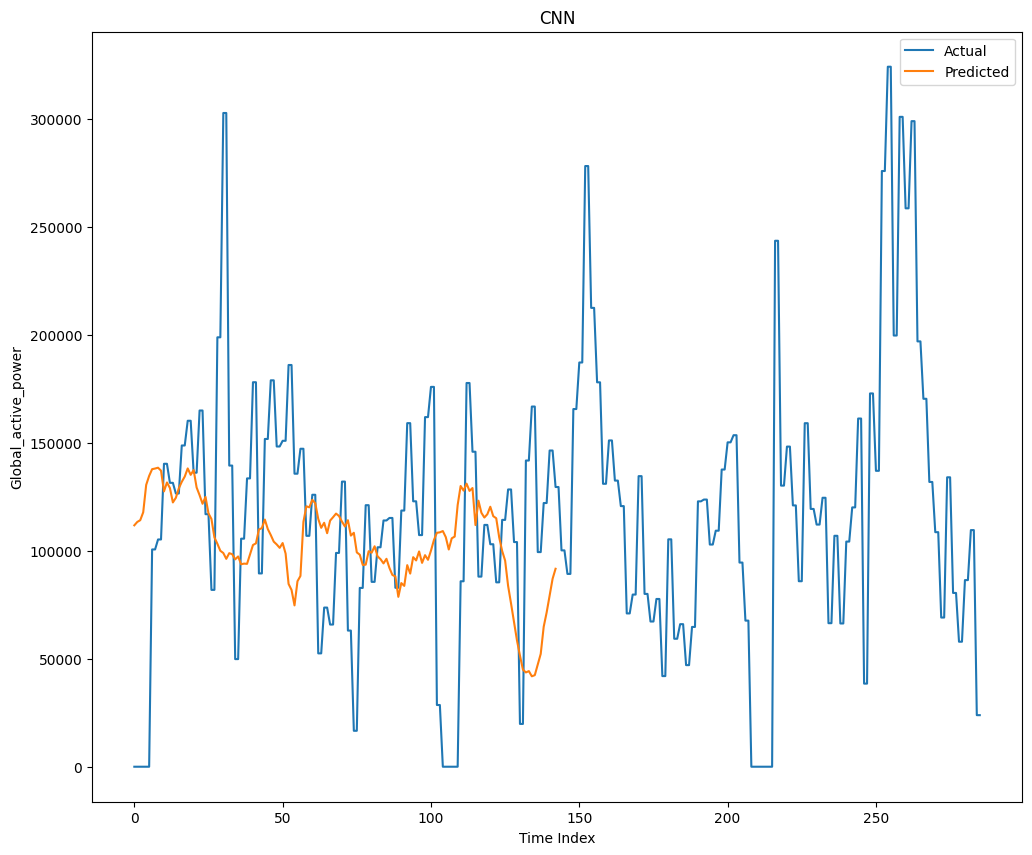

In [142]:
cnn_y_pred_scaled = Cnn.predict(X_test)
cnn_y_pred_inv = y_scaler.inverse_transform(cnn_y_pred_scaled)
cnn_y_test_inv = y_scaler.inverse_transform(y_test)
plt.figure(figsize=(12, 10))
plt.plot(cnn_y_test_inv, label='Actual')
plt.plot(cnn_y_pred_inv, label='Predicted')
plt.legend()
plt.title('CNN')
plt.xlabel('Time Index')
plt.ylabel('Global_active_power')
plt.show()

In [469]:
Rnn = Sequential()
Rnn.add(SimpleRNN(128, activation='tanh', input_shape=(train_x_cnn.shape[1],train_x_cnn.shape[2]),return_sequences=True))
Rnn.add(SimpleRNN(64, return_sequences=True,activation='tanh'))
Rnn.add(SimpleRNN(32,activation='tanh'))
Rnn.add(Dense(units=16, activation='relu'))
Rnn.add(Dense(y_train.shape[1],activation='softmax'))
Rnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [428]:
X_train.shape

(572, 12, 26)

In [358]:
print(Rnn.summary())

Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_45 (SimpleRNN)       │ (None, 10, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_46 (SimpleRNN)       │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_47 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 9)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,185 (383.54 KB)

 Trainable params: 98,185 (383.54 KB)

 Non-trainable params: 0 (0.00 B)

None


In [349]:
X_train.shape

(540, 52, 47)

In [470]:
Rnn_history = Rnn.fit(train_x_cnn,y_train,epochs=100,validation_split=0.1,callbacks=[early_stopping])

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.2043 - loss: 1.9769 - val_accuracy: 0.5172 - val_loss: 1.4484
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5872 - loss: 1.3940 - val_accuracy: 0.8621 - val_loss: 1.0456
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8060 - loss: 1.0613 - val_accuracy: 0.6379 - val_loss: 0.9770
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7931 - loss: 0.7850 - val_accuracy: 0.7931 - val_loss: 0.7471
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8300 - loss: 0.6483 - val_accuracy: 0.7069 - val_loss: 0.8290
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8839 - loss: 0.5209 - val_accuracy: 0.8621 - val_loss: 0.5700
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8816 - loss: 0.4284 - val_accuracy: 0.7759 - val_loss: 0.6796
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9004 - loss: 0.3658 - val_accuracy: 0.7414 -

In [471]:
y_pred = Rnn.predict(test_x_cnn)
y_pred = np.argmax(y_pred,axis=1)
print('-----------RNN-----------')
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
-----------RNN-----------
정확도: 0.3006993006993007
혼동행렬:
 [[ 5  2  0  0  1  0  0  2]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0  0  0 25  2  0  0]
 [ 0 27  0  0  0  8 22  0]
 [ 0  0  0  0  4  0  0  1]
 [ 0  0  0  0  0 19  3  0]
 [ 0  0  0  0  0  0  0  0]
 [ 1  0  0  0  6  0  0  7]]
분류보고서
               precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.22      1.00      0.36         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.11      0.80      0.20         5
           5       0.66      0.86      0.75        22
           6       0.00      0.00      0.00         0
           7       0.70      0.50      0.58        14

    accuracy                           0.30       143
   macro avg       0.31      0.46      0.31       143
weighted avg       0.24      0.30      0.24       143



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [183]:
help(LSTM)

Help on class LSTM in module keras.src.layers.rnn.lstm:

class LSTM(keras.src.layers.rnn.rnn.RNN)
 |  LSTM(units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, seed=None, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False, use_cudnn='auto', **kwargs)
 |  
 |  Long Short-Term Memory layer - Hochreiter 1997.
 |  
 |  Based on available runtime hardware and constraints, this layer
 |  will choose different implementations (cuDNN-based or backend-native)
 |  to maximize the performance. If a GPU is available and all
 |  the arguments to the layer meet the requirement of the cuDNN kernel
 |  (see below

In [472]:

Lstm = Sequential()
Lstm.add(LSTM(units=64, activation='tanh', return_sequences=True,input_shape=(train_x_cnn.shape[1],train_x_cnn.shape[2])))

Lstm.add(LSTM(units=32,activation='tanh',return_sequences=True))

Lstm.add(LSTM(units=16))

#출력층
Lstm.add(Dense(9, activation='softmax'))

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#print(X_train.shape)

(578, 4, 47)


In [474]:
y_pred = Lstm.predict(test_x_cnn)
y_pred = np.argmax(y_pred,axis=1)
print('-----------LSTM-----------')
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
-----------LSTM-----------
정확도: 0.2937062937062937
혼동행렬:
 [[ 7  2  0  0  0  0  0  1]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0  0  0 24  3  0  0]
 [ 0 23  0  0  4  3 27  0]
 [ 0  0  0  0  4  0  0  1]
 [ 0  0  0  0  0 18  4  0]
 [ 0  0  0  0  0  0  0  0]
 [ 3  0  0  0  6  0  0  5]]
분류보고서
               precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.24      1.00      0.39         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.11      0.80      0.19         5
           5       0.75      0.82      0.78        22
           6       0.00      0.00      0.00         0
           7       0.71      0.36      0.48        14

    accuracy                           0.29       143
   macro avg       0.31      0.46      0.32       143
weighted avg       0.25      0.29      0.24       143



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [ ]:
eval_df = pd.DataFrame({'Model': ['FNN', 'CNN', 'RNN', 'LSTM'],
                        'Accuracy': [accuracy_score(y_test_raw, np.argmax(Fnn.predict(X_test),axis=1)), 
                                     accuracy_score(y_test_raw, np.argmax(Cnn.predict(X_test),axis=1)), 
                                     accuracy_score(y_test_raw, np.argmax(Rnn.predict(X_test),axis=1)), 
                                     accuracy_score(y_test_raw, np.argmax(Lstm.predict(X_test),aixs=1))]})

In [210]:
X_train.shape[1]

4

In [166]:
## CNN 특징 추출
Cnn_F =Sequential()
Cnn_F.add(Conv1D(32,2, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
Cnn_F.add(Conv1D(64,2, activation='relu'))
Cnn_F.add(MaxPooling1D(2))
Cnn_F.add(Conv1D(128,2, activation='relu'))
Cnn_F.add(MaxPooling1D(2))
Cnn_F.add(Conv1D(256,2, activation='relu'))
Cnn_F.add(MaxPooling1D(2))


Cnn_F.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)              │ (None, 55, 32)         │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 54, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 27, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 26, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 12, 256)        │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 6, 256)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,880 (339.38 KB)

 Trainable params: 86,880 (339.38 KB)

 Non-trainable params: 0 (0.00 B)

In [468]:
train_x_cnn = Cnn_F.predict(X_train)
test_x_cnn = Cnn_F.predict(X_test)

train_x_cnn.shape

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


(536, 6, 256)